In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from plotnine import *
from scipy.stats import ttest_ind

In this notebook, we compute Fisher scores for the predictors in the summary data frames in `../../data/processed/partition*/`. We store them in data frames; we put the Fisher scores used in [the paper by Goodwin et al.](https://dx.doi.org/10.3847/1538-4357/adb4f6) in data frames with the same structure. We also compare our Fisher scores to those computed by Goodwin et al.; since we're trying to reproduce their results, they should be the same. We calculate Fisher scores using the functions below.

In [2]:
def calc_fisher_score(
        x: pd.Series, flare_flags: pd.Series, *, equal_var: bool = True
    ) -> float:
    result = ttest_ind(
        x[flare_flags], x[~flare_flags], equal_var=equal_var, nan_policy="omit"
    )
    return result.statistic**2

def calc_df_fisher_scores(df: pd.DataFrame) -> pd.DataFrame:
    fisher_scores = (
        df
        .drop(columns=["partition", "type", "flare_class", "ar_num", "file"])
        .apply(lambda x: calc_fisher_score(x, df["type"] == "FL"))
        .reset_index(name="fisher_score")
        .rename(columns={"index": "predictor"})
    )
    return fisher_scores

def calc_all_fisher_scores(
        summary_df: pd.DataFrame, corrected_summary_df: pd.DataFrame
    ) -> pd.DataFrame:
    fisher_scores = calc_df_fisher_scores(summary_df)
    fisher_scores.insert(0, "data_type", "uncorrected")
    corrected_fisher_scores = calc_df_fisher_scores(corrected_summary_df)
    corrected_fisher_scores.insert(0, "data_type", "corrected")
    all_fisher_scores = (
        pd.concat([fisher_scores, corrected_fisher_scores], ignore_index=True)
        .sort_values(["data_type", "predictor"], ignore_index=True)
    )
    return all_fisher_scores

We compute the Fisher scores for the predictors in our summary data frames.

In [3]:
reproduced = {}
for partition in range(1, 6):
    partition_dir = Path("..") / ".." / "data" / "processed" / f"partition{partition}"
    summary_df = pd.read_parquet(partition_dir / "summary_df.parquet")
    corrected_summary_df = pd.read_parquet(
        partition_dir / "corrected_summary_df.parquet"
    )
    reproduced[partition] = calc_all_fisher_scores(
        summary_df, corrected_summary_df
    )

Put the Fisher scores computed by Goodwin et al. in data frames.

In [4]:
improvements = {}
for partition in range(1, 6):
    improvements[partition] = pd.read_csv(
        Path("..") / ".." / f"Partition{partition}Improvements.csv"
    )

This is what one of Goodwin et al.'s data frames looks like:

In [5]:
improvements[1].head()

,Specs,Score,CORR_Specs,CORR_Score,IMP,Best_Score
0,ABSNJZH_max,18327.774353,ABSNJZH_CORRECTED_max,17591.465395,-4.017449,18327.774353
1,ABSNJZH_last_value,18049.456903,ABSNJZH_CORRECTED_last_value,17286.115323,-4.229166,18049.456903
2,SAVNCPP_max,16920.760643,SAVNCPP_CORRECTED_max,17220.596348,1.771999,17220.596348
3,SAVNCPP_last_value,16592.883968,SAVNCPP_CORRECTED_last_value,16775.566490,1.100969,16775.566490
4,ABSNJZH_mean,16655.129744,ABSNJZH_CORRECTED_mean,15832.259690,-4.940640,16655.129744


Each predictor name in the `CORR_Specs` column is the corresponding predictor name in the `Specs` column with `"CORRECTED_" inserted in the middle.

In [6]:
for partition in range(1, 6):
    assert (
        improvements[partition]
        .eval("Specs == CORR_Specs.str.replace('CORRECTED_', '')")
        .all()
    )

The function below will be used to restructure Goodwin et al.'s data frames so that they have the same tidy structure as our data frames.

In [7]:
def restructure_improvements(improvements: pd.DataFrame) -> pd.DataFrame:
    restructure = (
        improvements
        .drop(columns=["CORR_Specs", "IMP", "Best_Score"])
        .rename(
            columns={
                "Specs": "predictor",
                "Score": "uncorrected",
                "CORR_Score": "corrected"
            }
        )
        .melt(
            id_vars="predictor", var_name="data_type", value_name="fisher_score"
        )
        [["data_type", "predictor", "fisher_score"]]
        .sort_values(["data_type", "predictor"], ignore_index=True)
    )
    return restructure

Restructure Goodwin et al.'s data frames.

In [8]:
original = {}
for partition in range(1, 6):
    original[partition] = restructure_improvements(improvements[partition])

We next compare the reproduced Fisher scores to the original scores. For each partition, we create a data frame with the reproduced and original scores in different columns.

In [9]:
score_comparisons = {}
for partition in range(1, 6):
    score_comparisons[partition] = (
        pd.merge(
            original[partition], reproduced[partition],
            on=["data_type", "predictor"], suffixes=["_original", "_reproduced"]
        )
        .assign(
            diff=lambda df: df["fisher_score_reproduced"] - df["fisher_score_original"],
            rel_diff=lambda df: df["diff"] / df["fisher_score_original"]
        )
    )

The function below plots the reproduced scores against the original scores, with one panel for the scores computed from the uncorrected data and another for the scores computed from the corrected data.

In [10]:
def plot_score_comparison(
        partition: int, score_comparison: pd.DataFrame
    ) -> ggplot:
    plot_data = score_comparison.copy()
    plot_data["data_type"] = pd.Categorical(
        plot_data["data_type"].str.capitalize() + " Data",
        categories=["Uncorrected Data", "Corrected Data"]
    )
    plot = (
        ggplot(
            plot_data,
            aes(x="fisher_score_original", y="fisher_score_reproduced")
        ) +
        facet_wrap("data_type") +
        geom_point(alpha=0.3) +
        geom_abline(intercept=0, slope=1) +
        geom_smooth(se=False, color="red") +
        coord_fixed() +
        labs(
            x="Fisher Score (Original)", y="Fisher Score (Reproduced)",
            title=f"Partition {partition}",
            caption="Scores are equal on black line\nRed curve is a LOESS smooth"
        ) +
        theme_bw()
    )
    return plot

The plots below show that for each partition, the reproduced score is essentially the same as the original score for virtually all of the predictors. It isn't clear to me why there are some predictors for which the scores are different. However, there don't appear to be any predictors for which the difference is very large.

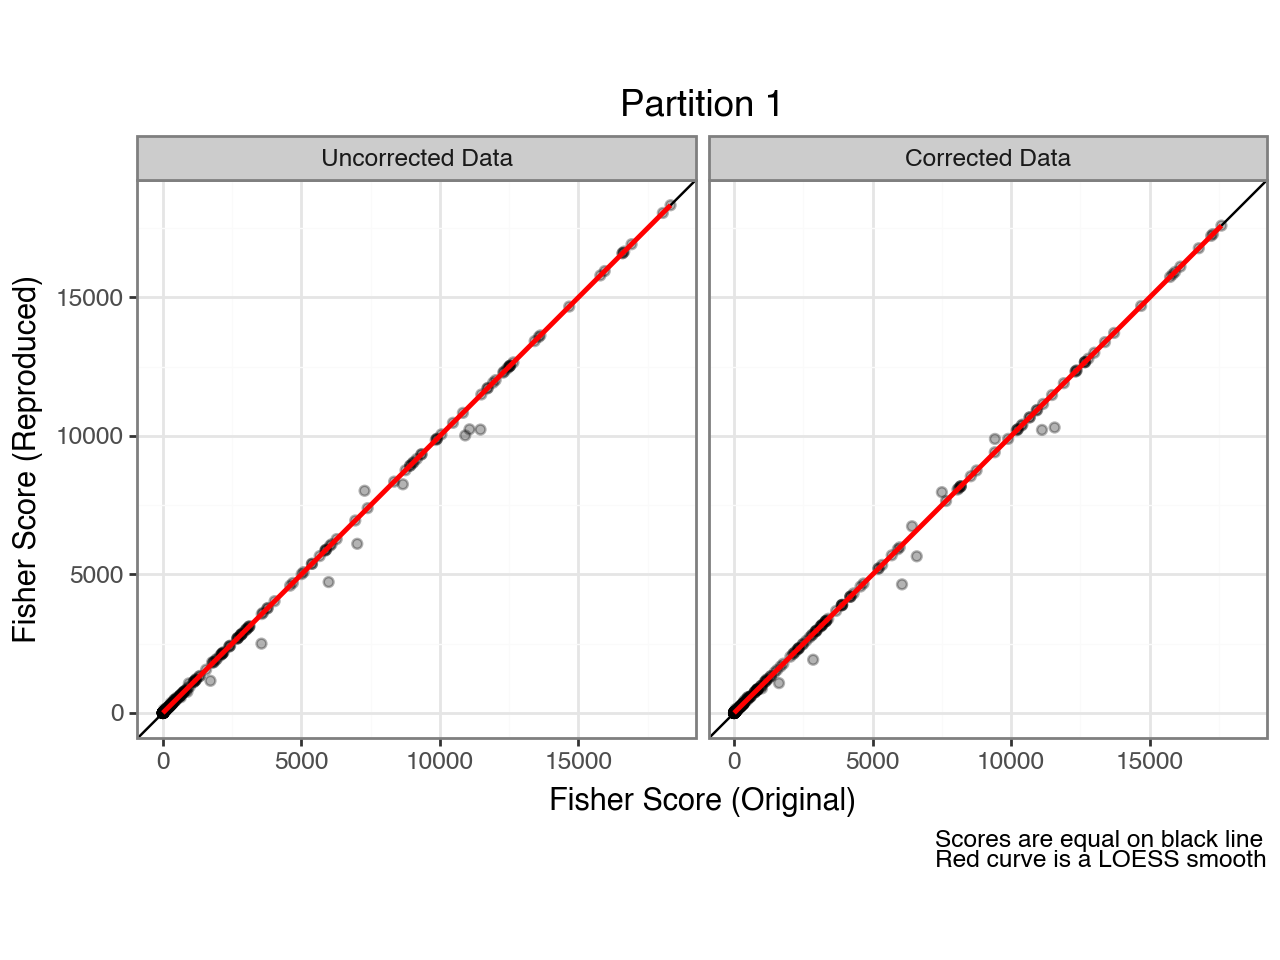

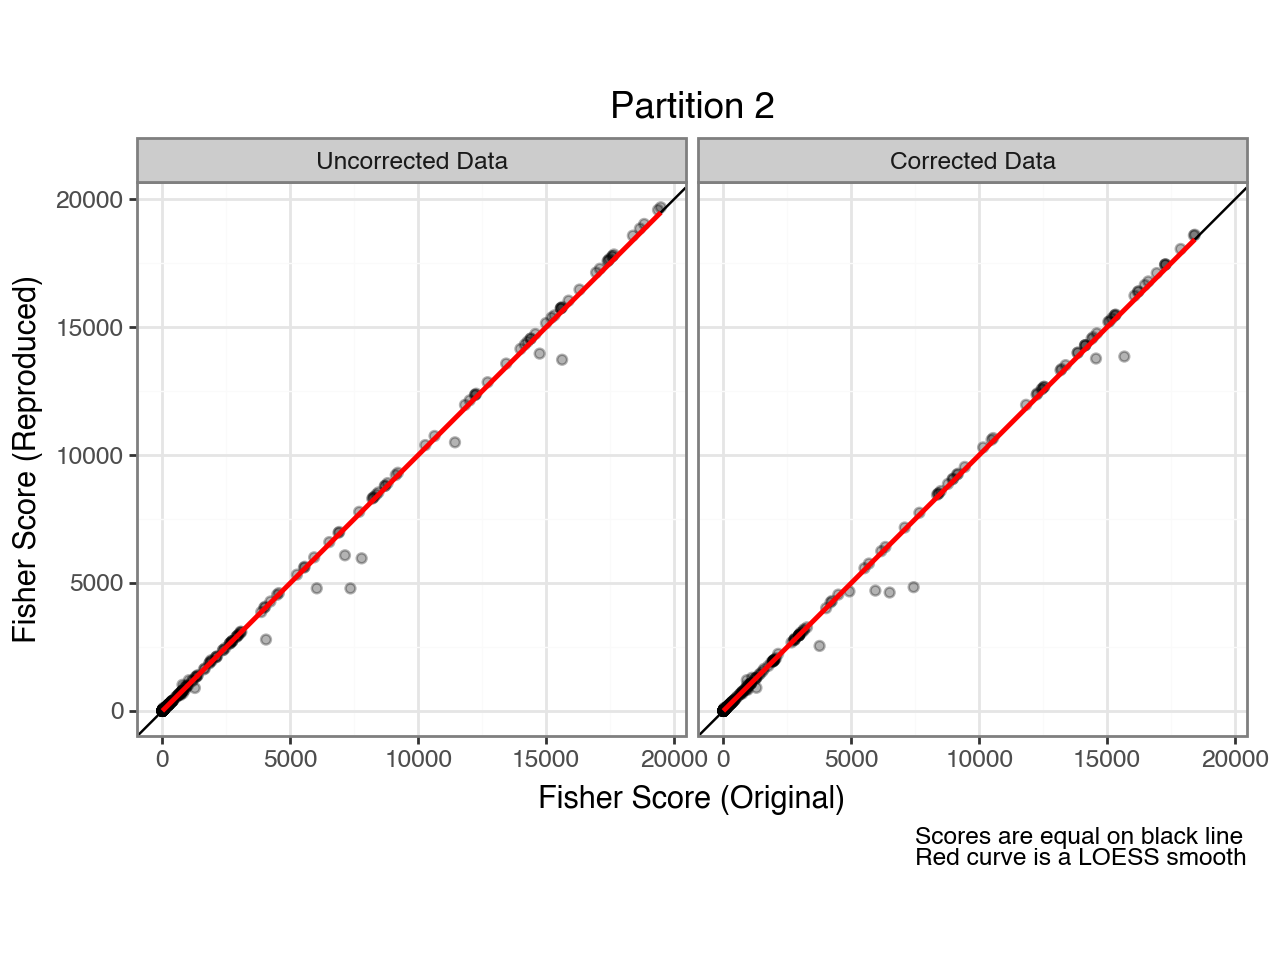

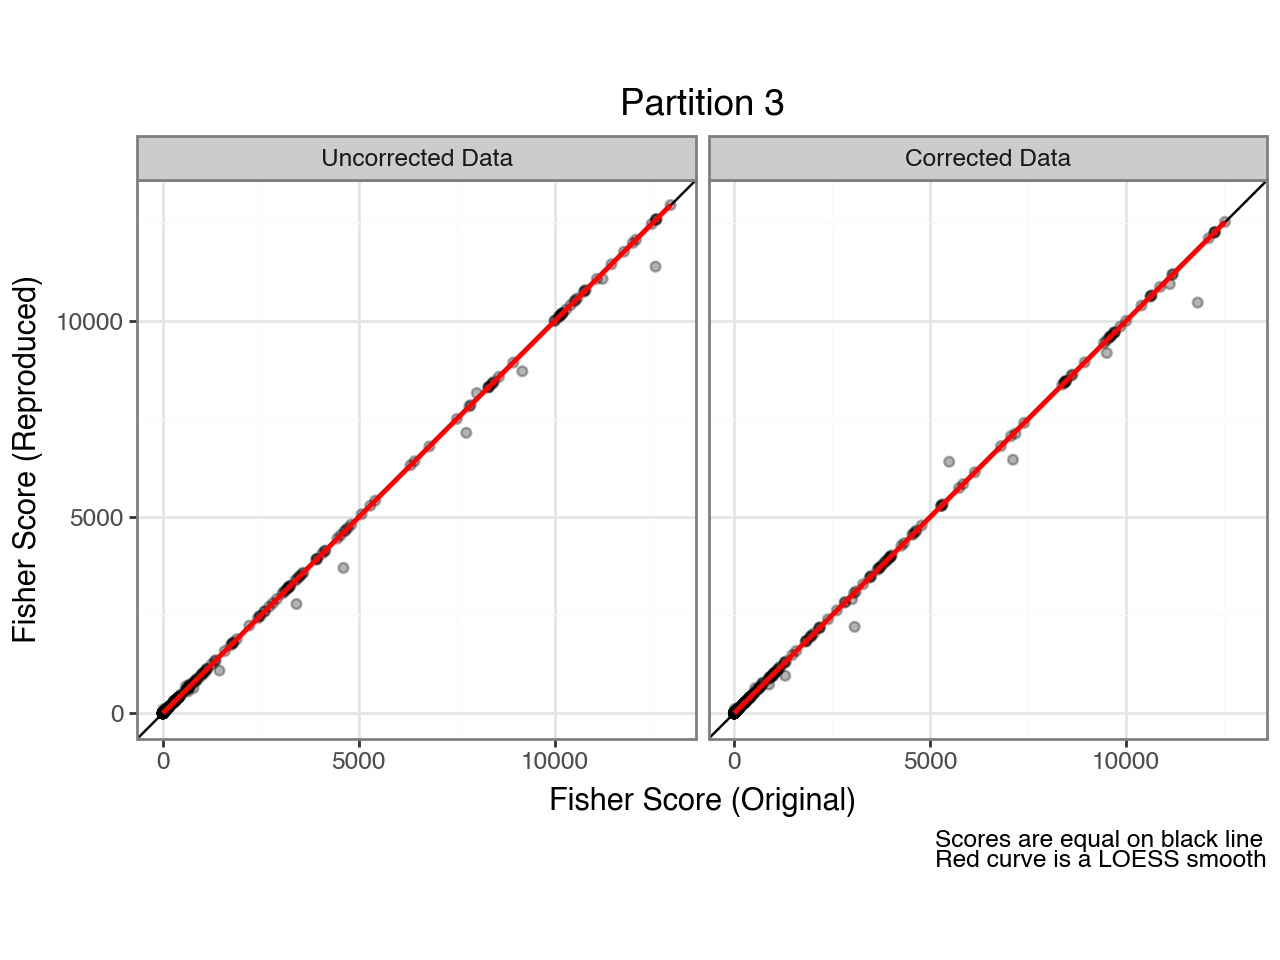

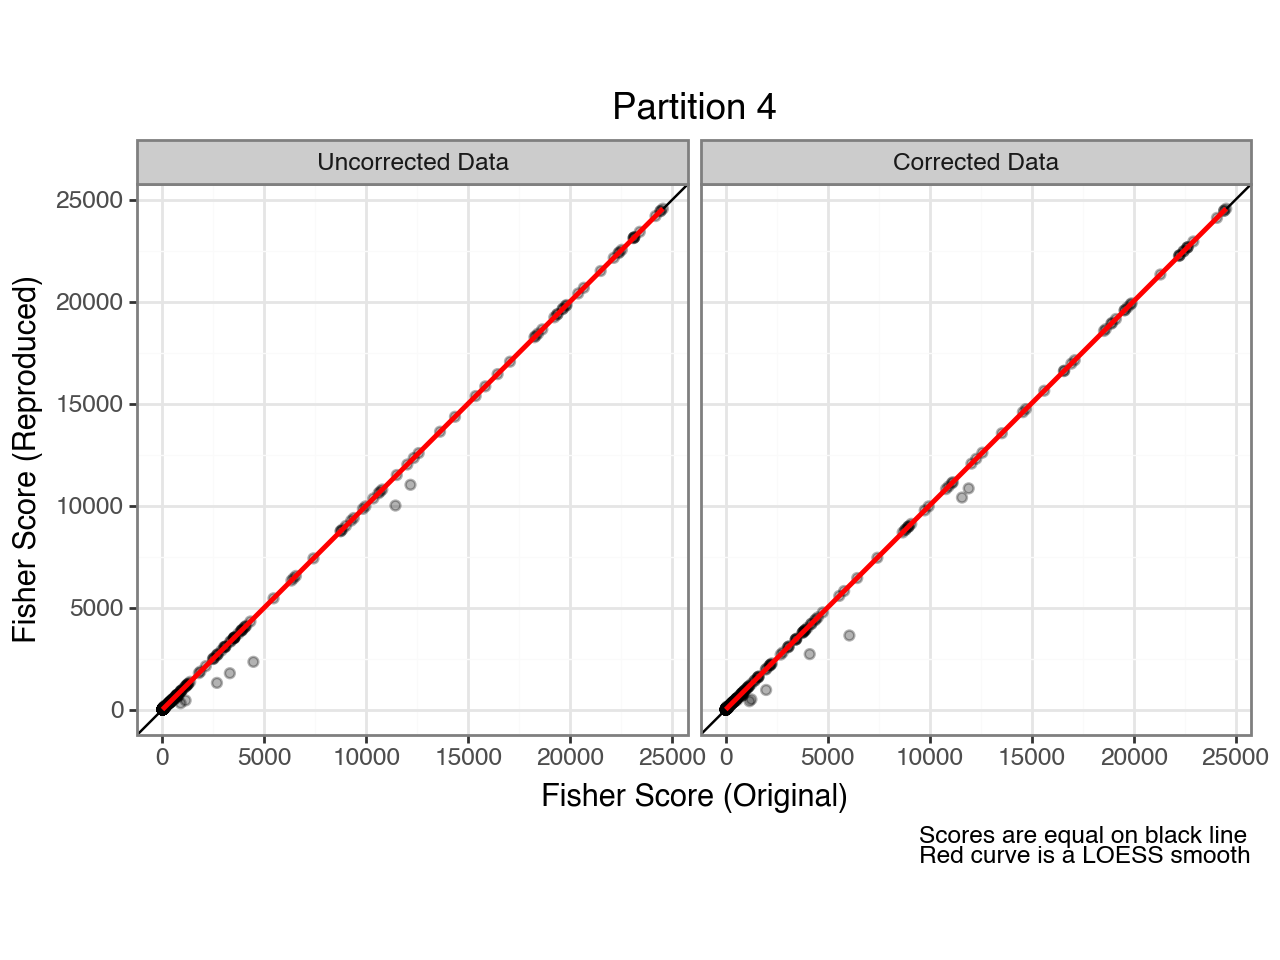

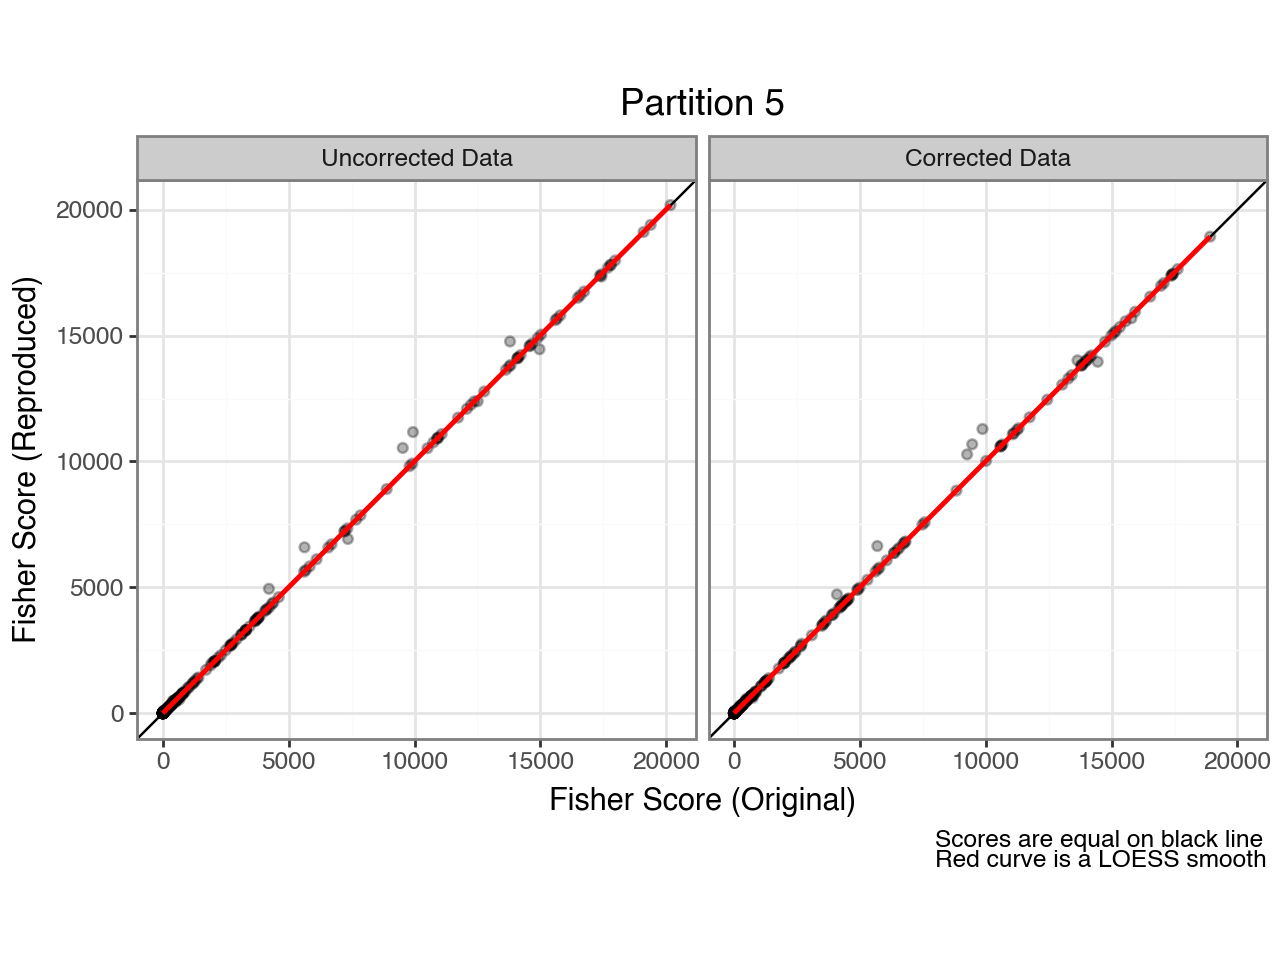

In [11]:
for partition, score_comparison in score_comparisons.items():
    plot_score_comparison(partition, score_comparison).show()

We next evaluate how the predictor rankings have changed. The function below ranks the predictors by the improvement in the Fisher score caused by the corrections, with the highest-ranked predictor being the one with the biggest improvement.

In [12]:
def rank_predictors(df: pd.DataFrame) -> pd.DataFrame:
    predictor_ranking = (
        df
        .pivot(index="predictor", columns="data_type", values="fisher_score")
        .reset_index()
        .rename(
            columns={
                "corrected": "corrected_fisher_score",
                "uncorrected": "uncorrected_fisher_score"
            }
        )
        .assign(
            max_fisher_score=lambda x: np.maximum(
                x["corrected_fisher_score"], x["uncorrected_fisher_score"]
            )
        )
        .sort_values("max_fisher_score", ascending=False, ignore_index=True)
        .reset_index(names="rank")
        .assign(rank=lambda x: x["rank"] + 1)
    )
    return predictor_ranking

For both the original data and the reproduced data, for each partition, we rank the predictors.

In [13]:
original_rankings = {}
for partition in range(1, 6):
    original_rankings[partition] = rank_predictors(original[partition])

reproduced_rankings = {}
for partition in range(1, 6):
    reproduced_rankings[partition] = rank_predictors(reproduced[partition])

For each partition, for each predictor, we get the rank in the original data and the rank in the reproduced data.

In [14]:
ranking_comparisons = {}
for partition in range(1, 6):
    ranking_comparisons[partition] = (
        pd.merge(
            original_rankings[partition],
            reproduced_rankings[partition],
            on="predictor",
            suffixes=["_original", "_reproduced"]
        )
    )

For a given partition, the following function plots the rank in the reproduced data against the rank in the original data, for just the top 25 predictors in the original data, i.e., the predictors that were used in models by Goodwin et al.

In [15]:
def plot_rank_comparison(
        partition: int, ranking_comparison: pd.DataFrame
    ) -> ggplot:
    plot_data = ranking_comparison.query("rank_original <= 25")
    plot = (
        ggplot(plot_data, aes(x="rank_original", y="rank_reproduced")) +
        geom_point() +
        geom_abline(intercept=0, slope=1) +
        geom_hline(yintercept=25, linetype="dashed") +
        labs(
            x="Rank (Original)", y="Rank (Reproduced)",
            title=f"Partition {partition}",
            caption="Ranks are equal on solid line\nDashed line is at 25"
        ) +
        theme_bw()
    )
    return plot

The plots below show that the top predictors in the original data are largely still the top predictors in the reproduced data. For the most part, the predictors that are no longer at the top in the reproduced data were just barely at the top, i.e., ranked near 25.

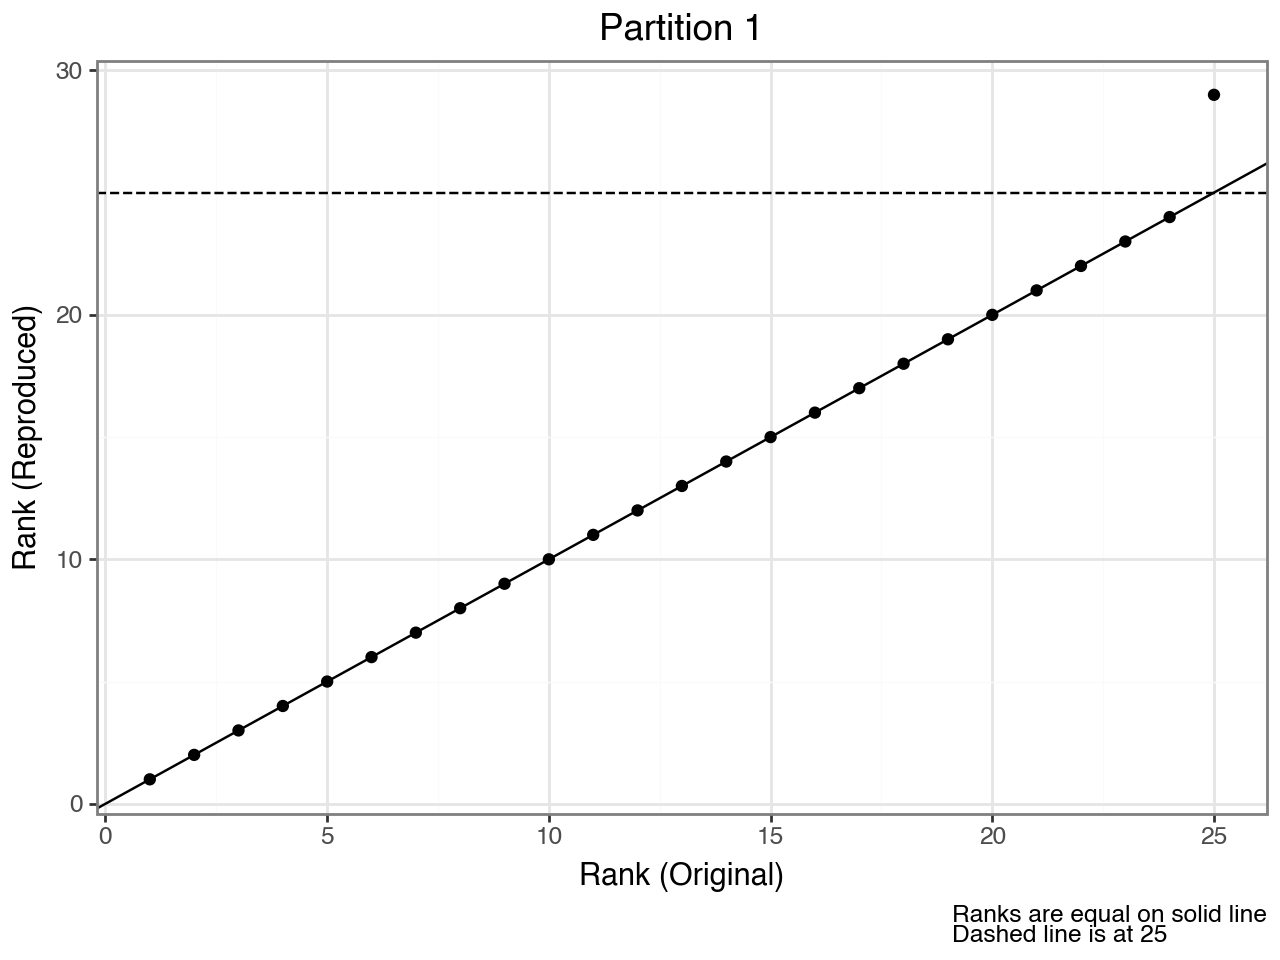

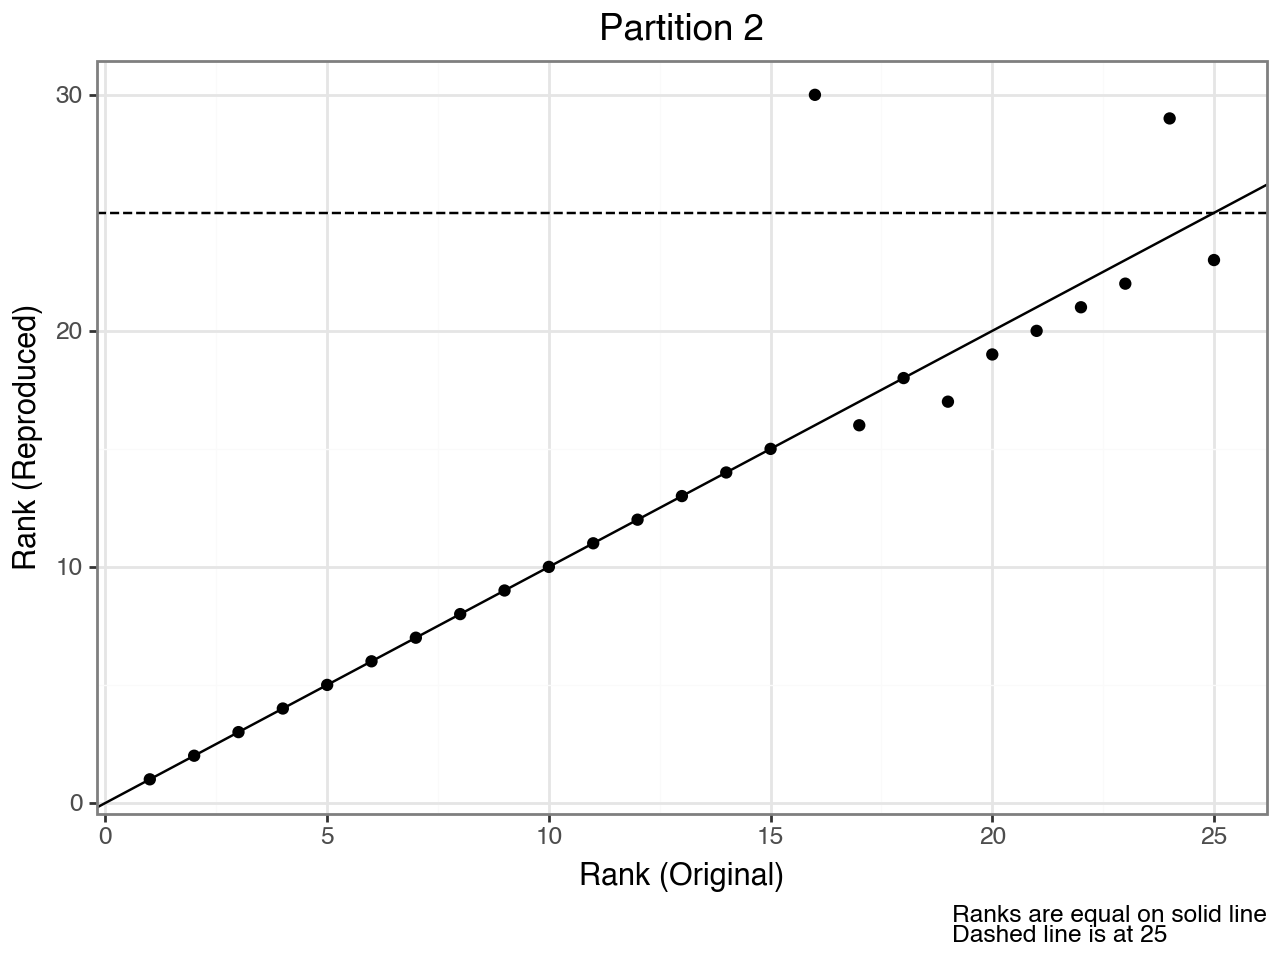

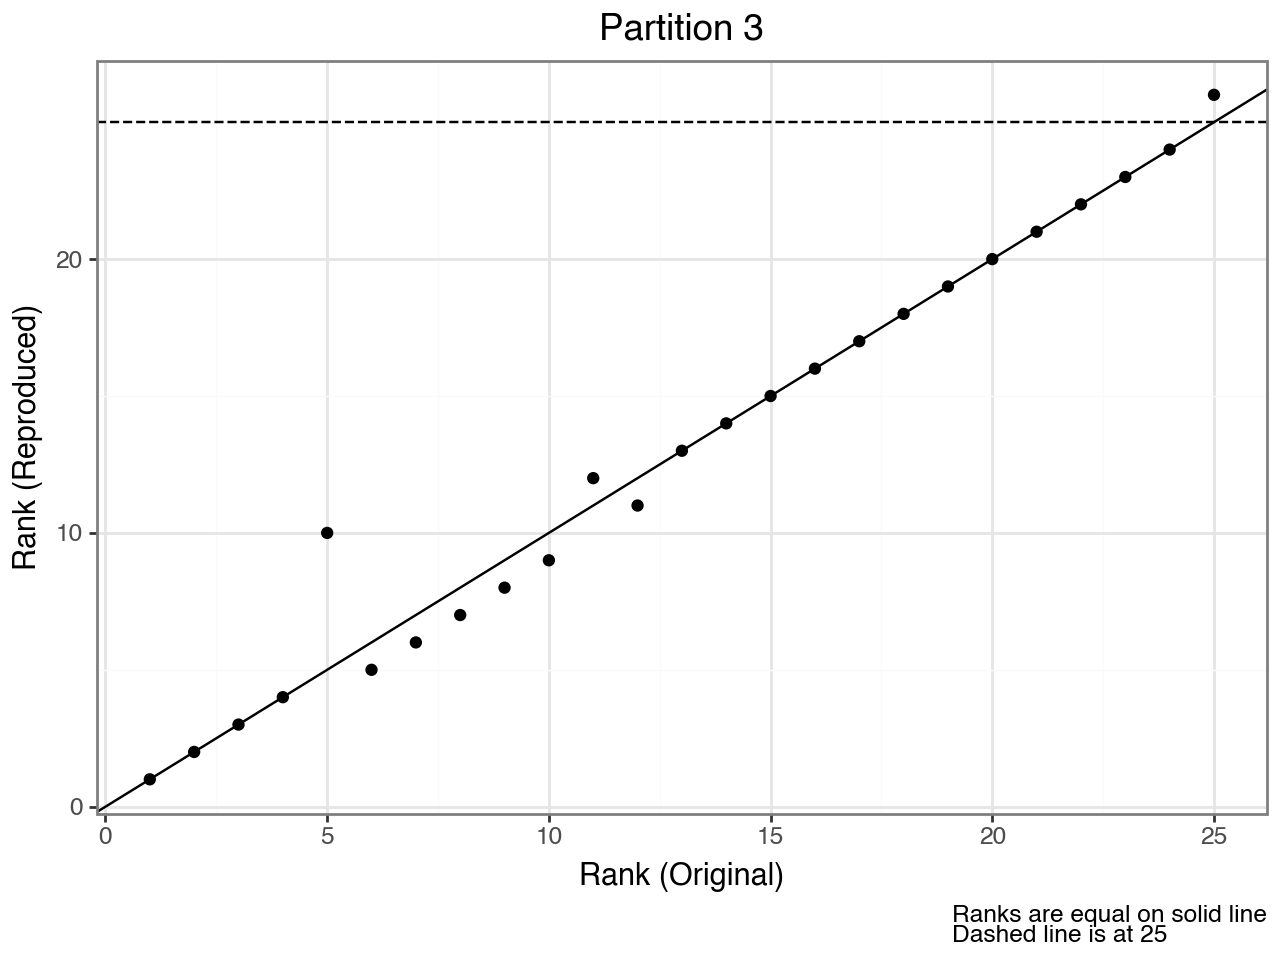

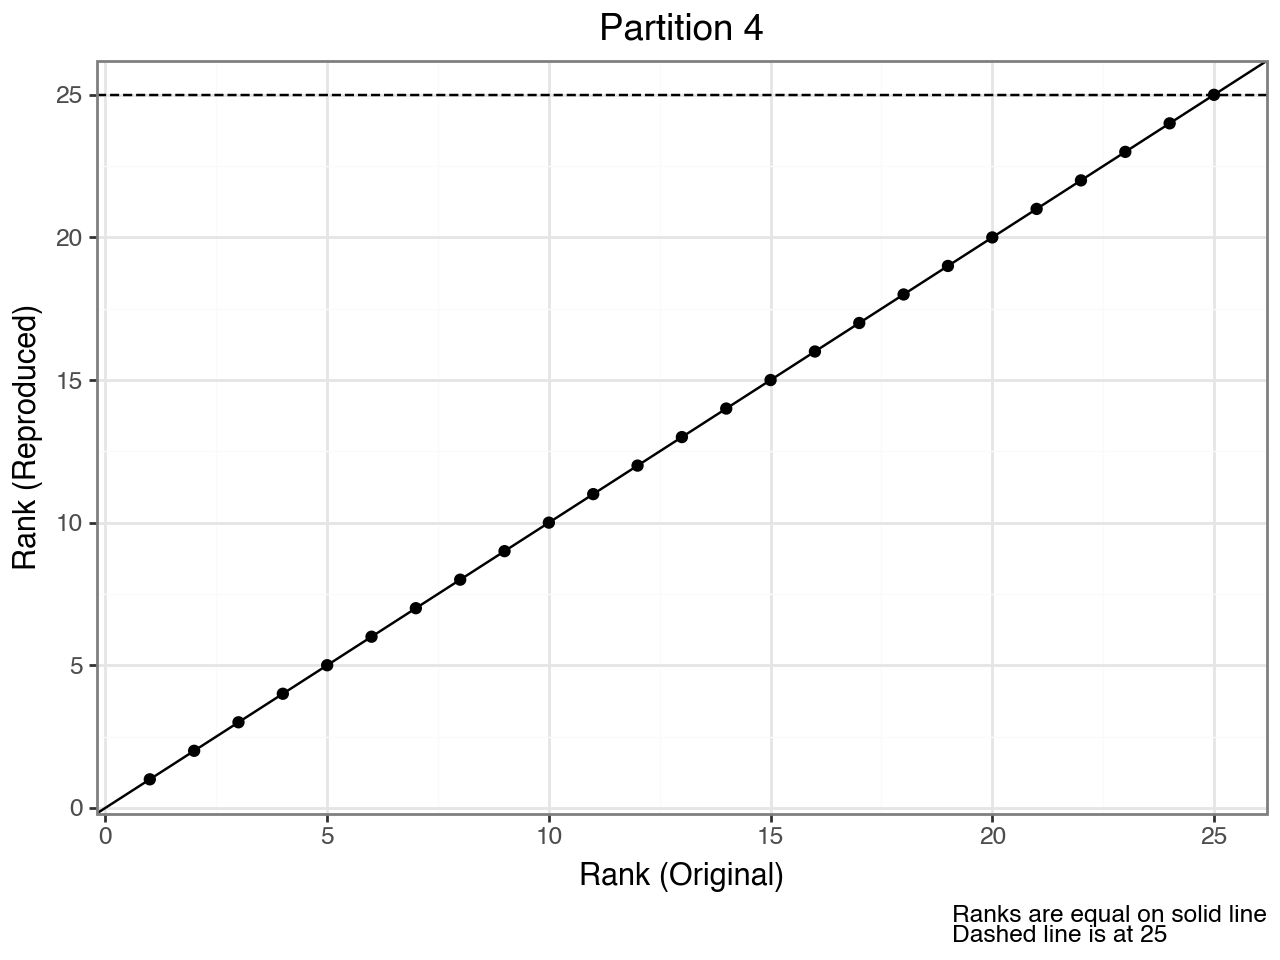

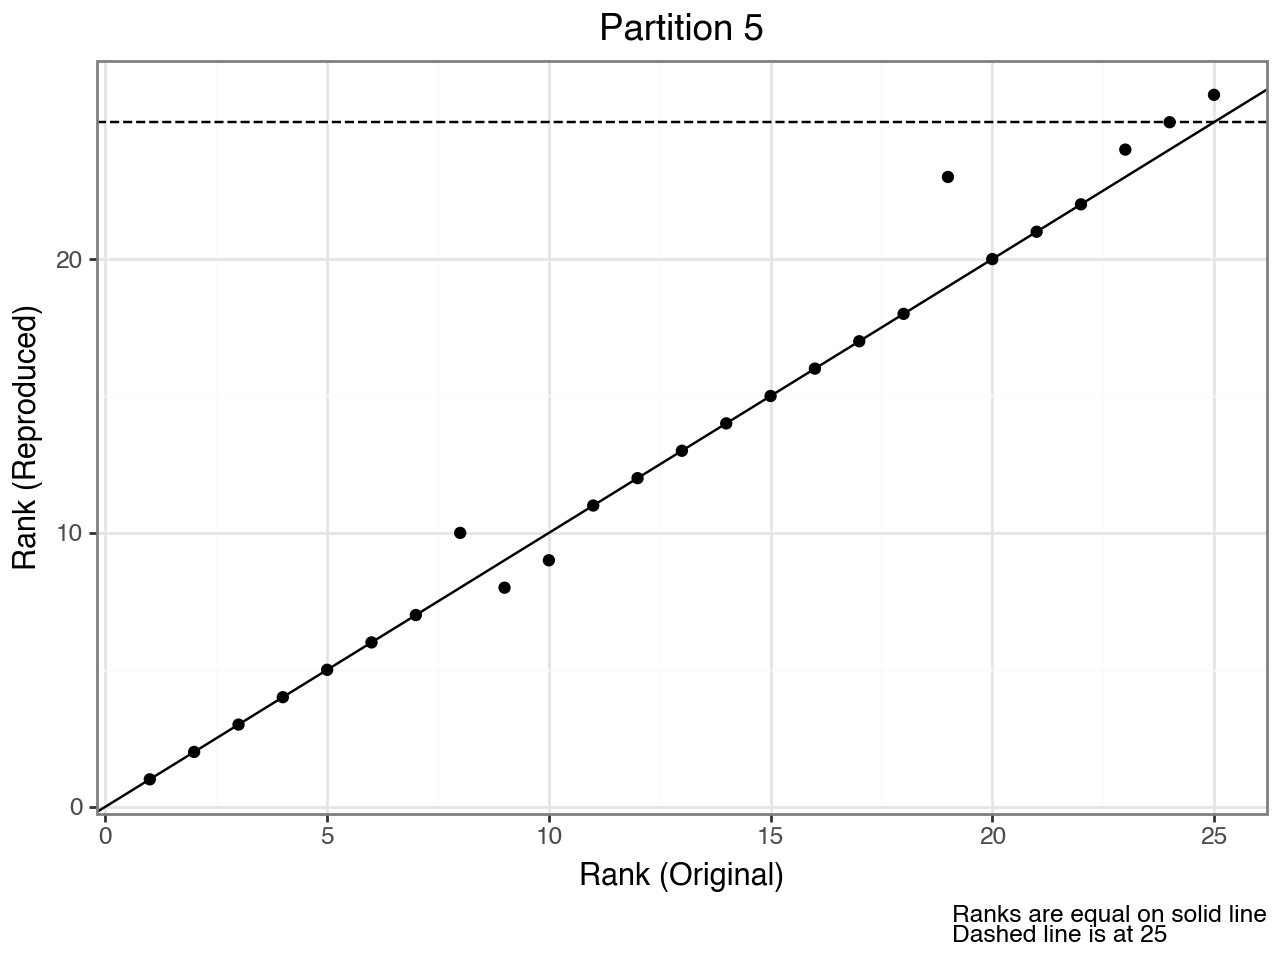

In [16]:
for partition, ranking_comparison in ranking_comparisons.items():
    plot_rank_comparison(partition, ranking_comparison).show()

Save the rankings in `feature_rankings/` so they can be used in `../model_training/train_model.py`.

In [17]:
rankings_dir = Path("feature_rankings")
for partition, original_ranking in original_rankings.items():
    original_ranking.to_parquet(
        rankings_dir / "original" / f"partition{partition}.parquet"
    )
for partition, reproduced_ranking in reproduced_rankings.items():
    reproduced_ranking.to_parquet(
        rankings_dir / "reproduced" / f"partition{partition}.parquet"
    )